# MDD with physics-aware factorization-based low-rank regularization

The purpose of this notebook is to demonstrate the importance of the regularization parameter $\lambda$ to the efficiency of our proposed method. It also reproduces the first example in the paper

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
from numpy import inf

We first define functions to calcualte the residual and gradient of MDD with the proposed low-rank regularization

In [2]:
def diffQQt(xs, ia, ib):
    xs = xs[0]
    r = ia.dot(xs@xs.T) - ib
    return r

def gradQQt(xs, ir, ia):
    
    xs = xs[0] 
    AhR = ia.T.conj().dot(ir)
    
    dd = (AhR +  AhR.T).dot(xs.conj())   

    return dd

Define the proximal operator of Frobenious norm:

In [3]:
def prox_Fro(v, t, lam):

    nv = norm(v,ord='fro')
    v  = v/(1+lam/t)
    
    nnv = norm(v, ord='fro')
    
    return v, nv**2 * 0.5, nnv**2 * 0.5

Below define the main function to solve the proposed MDD in an alternating style

In [4]:
def ipalm(grads, proxs, tau_guess, inc, diff, argv, ia, ib, xs0): 
    
    nblocks=len(grads)
    # initialize states for inertia
    xs1=list(xs0)
    xs2=list(xs0)
    
    it=0 
    
    lam = argv.lam

    nv, nnv = np.zeros(nblocks), np.zeros(nblocks)

    total_msf_old = inf

    while it < argv.nit: # and err > tol: 
        reg_msf = 0.0    
        #compute inertial coefficients
        if 0 == argv.inertia: 
            inertia = it/(it+3.0)
        else:
            inertia = argv.inertia
        
        for i in range(nblocks):

            yi = xs1[i] + inertia * (xs1[i] - xs0[i])
            zi = xs1[i] + inertia * (xs1[i] - xs0[i])
             
            xs2[i] = zi
    
            # Estimate the resuial and gradient with the current x
            res = diff(xs2, ia, ib)
            data_msf_cur = 0.5*norm(res, ord='fro')**2 
            gg = grads[i](xs2, res, ia)
                        
            ############################################################## 

            cnt = 0
            while(True):           
    
                tau = tau_guess[i] * inc[i]**cnt
                # print(cnt, tau) 
                y_tmp = yi - 1.0/tau * gg
                
                # x_new, nv[i], nnv[i] = proxs[i](y_tmp, tau, lam[i])
                x_new, nv[i], nnv[i] = proxs[i](y_tmp, tau, lam[i])
                xs2[i] = x_new
                res = diff(xs2, ia, ib)

                data_msf_new = 0.5*norm(res, ord='fro')**2 
                # F(P(y_k))<Q(P(y_k), y_k)
                if data_msf_new < data_msf_cur + 0.5 * ( norm(x_new - y_tmp, ord='fro')**2 * tau - norm(gg, ord='fro')**2 / tau ) or cnt > 5: 
                    break
                cnt += 1
            
            # tau_guess[i] = tau
            reg_msf += nv[i]*lam[i]/tau

        total_msf_cur = reg_msf + data_msf_cur
        
        if argv.verbose:
            print("%15.3f%18d"%(total_msf_cur,cnt+1), end='', flush=True)
            for i in range(nblocks):
                print("%15.3f%15.3f"%(nv[i], nnv[i]), end='', flush=True)
            print("\n")
       
        if abs(total_msf_cur/total_msf_old-1.0) < argv.tol:
       
            break
        
        total_msf_old = total_msf_cur
      
        xs0 = list(xs1)
        xs1 = list(xs2)
        it+=1 
        
    
    return xs1

## Data loading

In [5]:
dat = np.load('../data/pup_pdown_overthrust.npz', allow_pickle=True)

pup_f   = dat['pup']

pdown_f = dat['pdown']

nt = 1600

In [6]:
energy = [np.linalg.norm(ipdown, 'fro') for ipdown in pdown_f] 

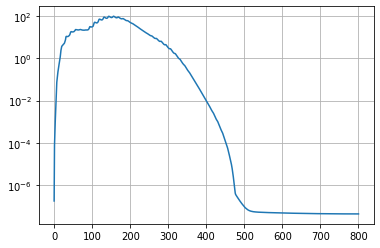

In [7]:
# ifstart and ifend can be determined from the figure below.
plt.yscale("log")
plt.plot(energy)
plt.grid()

In [8]:
ns, nr = pdown_f[0].shape
nk = nr//4 

## The proposed MDD with $\lambda=0$ 

In [9]:
ret = []

gradlist=[gradQQt]
proxlist=[prox_Fro]
inc = [2.0]

class args:
    lam = [0,]
    nit = 2000000
    inertia = 0
    verbose = False
    tol = 2e-4

ifstart, ifend = 0, 540
  
for idx in range(ifstart, ifend):
    
    ia = pdown_f[idx]
    ib = pup_f[idx]
    
    x0 = np.eye(nr, nk) +  np.eye(nr, nk)*1j
    
    tau_guess = [norm(ia, 'fro')**2]
    x1 = ipalm(gradlist, proxlist, tau_guess, inc, diffQQt, args, ia, ib, [x0,])
    ret.append(x1[0])

In [10]:
ret = np.array(ret)
g0 = np.matmul(ret, ret.transpose(0,2,1))
g0 = np.fft.irfft(g0, n=nt, axis=0)

## The proposed MDD with $\lambda=0.1$

In [11]:
ret = []

args.lam = [0.1]
 
for idx in range(ifstart, ifend):
    
    ia = pdown_f[idx]
    ib = pup_f[idx]
    
    x0 = np.eye(nr, nk) +  np.eye(nr, nk)*1j
    
    tau_guess = [norm(ia, 'fro')**2]
    x1 = ipalm(gradlist, proxlist, tau_guess, inc, diffQQt, args, ia, ib, [x0,])
    ret.append(x1[0])

In [12]:
ret = np.array(ret)
g1 = np.matmul(ret, ret.transpose(0,2,1))
g1 = np.fft.irfft(g1, n=nt, axis=0)

Text(0.5, 1.0, '$\\lambda=0.1$')

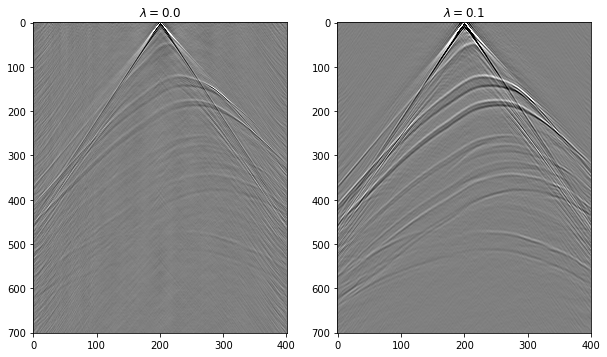

In [13]:
fig, axs = plt.subplots(1,2, figsize=(10,8))
pclip = 0.05

dat = g0[:701, 201] 
cc = np.abs(dat).max()
axs[0].imshow(dat, aspect=0.7, vmin=-cc*pclip, vmax=cc*pclip, cmap="gray")
title = '$\lambda=0.0$'
axs[0].set_title(title)


dat = g1[:701, 201] 
cc = np.abs(dat).max()
axs[1].imshow(dat, aspect=0.7, vmin=-cc*pclip, vmax=cc*pclip, cmap="gray")
title = '$\lambda=0.1$'
axs[1].set_title(title)